In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import sys
from os import system
from IPython.display import clear_output
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import phik 
import seaborn as sns
from phik import resources, report
from phik.report import plot_correlation_matrix
from itertools import combinations
import random
from tabulate import tabulate
from IPython.display import display, HTML
import graphviz
import networkx as nx
import itertools

In [2]:
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass
with add_path('/home/hshadman/.local/lib/python3.7/site-packages'):
    matplotlib = __import__('matplotlib')

In [3]:
matplotlib.__version__

'3.5.3'

In [4]:

from graphviz import Digraph
gra = Digraph()
gra.node('a', 'Machine Learning Errors')

gra.node('b', 'RMSE')

gra.node('c', 'MAE')
gra.edges(['ab', 'ac'])

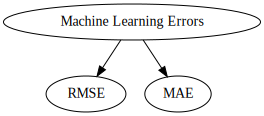

In [5]:
gra

In [6]:
print(gra.source)

digraph {
	a [label="Machine Learning Errors"]
	b [label=RMSE]
	c [label=MAE]
	a -> b
	a -> c
}


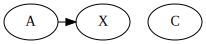

In [7]:
gra = Digraph()
with gra.subgraph() as i:

    i.attr(rank='same')

    i.node('A')

    i.node('X')

gra.node('C')
gra.edges(['AX'])
gra


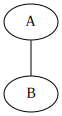

In [8]:
import graphviz
g = graphviz.Graph()
g.node('A')
g.node('B')
g.edge('A','B')
g

# load functions 
# load the datasets, set cutoff values, correlation method (these are done individually so the system saves them globallly)

In [9]:
gtex_toil_dataset = '../gtex_RSEM_gene_tpm.gz'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_toil_pancanc = "../gtex_and_tcga/tcga_RSEM_gene_tpm.gz"
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
tcga_toil_sampinfo = "../gtex_and_tcga/TCGA_phenotype_denseDataOnlyDownload.tsv.gz"
tcga_toil_clincinfo = "../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp"
opposing_corr_cutoff = 0.1


In [10]:
#functions for data processing
def gtex_data_processing(gtex_toil_dataset):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']
    gtex_breast_data_all = pd.read_csv(gtex_toil_dataset,sep='\t')
    gtex_breast_data_all=gtex_breast_data_all.set_index('sample').copy()

    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]

    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    gtex_breast_data_all.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    gtex_breast_data_all=gtex_breast_data_all.loc[gtex_breast_data_all.index.isin(list(gene_map.id.values))]
    gtex_breast_data_all=pd.concat([gtex_breast_data_all,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:gtex_breast_data_all.shape[1]]
    gtex_breast_data_all=gtex_breast_data_all.T.astype('float').copy()
    df_int = gtex_breast_data_all.copy()
    #drop unwanted integrins    
    df_int=df_int.drop([undesired_integrin for undesired_integrin in df_int.columns if undesired_integrin in unwanted_integrins],axis=1)
    #drop duplicate gene names (if any) 
    df_int=df_int.loc[:,~df_int.columns.duplicated()]    
    
    gtex_toil_phenotype = pd.read_csv('../GTEX_phenotype.gz',sep='\t')
    #subset for breast
    gtex_toil_phenotype = gtex_toil_phenotype[gtex_toil_phenotype['body_site_detail (SMTSD)']=='Breast - Mammary Tissue']
    #subset for female gender
    gtex_toil_phenotype = gtex_toil_phenotype[gtex_toil_phenotype._gender=='female']

    #select breast female gtex gene expression data
    df_int=df_int.loc[df_int.index.isin(gtex_toil_phenotype.Sample.values)].copy()
    
    return df_int

def tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    global tcga_brca_df, tcga_brca_sample_info
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]
    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop metastatic from main sample type data frame
    #tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]
 
    #separate normal and primtum (remember primary tumor contains multiple stages)
    tcga_brca_normal_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Solid Tissue Normal']
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']

    #drop index of samples not in tcga_brca_df
    tcga_brca_normal_patients = tcga_brca_normal_patients.drop(non_match for non_match in tcga_brca_normal_patients.index.values if non_match not in tcga_brca_df.columns)
    tcga_brca_primtum_patients = tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 


    #make sure both normal and tumor patients match, and drop patients not in tcga_brca_df
    matched_patient_index_list=[]
    for patient in tcga_brca_primtum_patients._PATIENT.values:
        if patient in tcga_brca_normal_patients._PATIENT.values and patient in ['-'.join(patient_id.split('-')[0:3]) for patient_id in tcga_brca_df.columns]:
            matched_patient_index_list.append(tcga_brca_sample_info[tcga_brca_sample_info._PATIENT==patient].index.values)
    matched_patient_list=tcga_brca_sample_info.loc[[x for l in matched_patient_index_list for x in l]].copy()


    # matched_patient_id_list=pd.Index(tcga_brca_normal_patients['_PATIENT']).intersection(pd.Index(tcga_brca_primtum_patients['_PATIENT']))
    # matched_patient_index_list=tcga_brca_sample_info[tcga_brca_sample_info._PATIENT.isin(matched_patient_id_list)].index.values
    # matched_patient_list = tcga_brca_sample_info.loc[[l for l in matched_patient_index_list]].copy()
    # #ensure samples are present in tcga_brca_df
    # matched_patient_list=matched_patient_list.loc[matched_patient_list.index.intersection(pd.Index(tcga_brca_df.columns))]

    #separate normal and primary tumor
    normal_matched_patient_list=matched_patient_list[matched_patient_list.sample_type=='Solid Tissue Normal']
    primtum_matched_patient_list = matched_patient_list[matched_patient_list.sample_type=='Primary Tumor']

    #matched normal and primary tumor samples
    tcga_brca_df_normal_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(normal_matched_patient_list.index.values)]]
    tcga_brca_df_primtum_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(primtum_matched_patient_list.index.values)]]

    #test to see if normal and primary tumor patient IDs are a match
    for i in [patient_id.split('-')[2] for patient_id in tcga_brca_df_normal_matched.columns]:
        if i not in [patient_id.split('-')[2] for patient_id in tcga_brca_df_primtum_matched.columns]:
            print('trouble')

    #TCGA brca normal ALL
    tcga_brca_df_normal_all = tcga_brca_df.T.loc[tcga_brca_normal_patients.index.values].copy()
    # dataframe with all TCGA primary tumor samples (not necessarily matched)
    tcga_brca_df_primtum_all= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_normal_matched':tcga_brca_df_normal_matched,
           'tcga_brca_df_primtum_matched':tcga_brca_df_primtum_matched,
           'tcga_brca_df_normal_all':tcga_brca_df_normal_all,
           'tcga_brca_df_primtum_all':tcga_brca_df_primtum_all}

def correlation_selected_gene(provided_dataset,interest_gene,correlation_method):
    dataset_corr = provided_dataset.corrwith(provided_dataset[interest_gene],
                                             method=correlation_method).drop(interest_gene)
    dataset_corr = dataset_corr.dropna(axis=0,how='any')
    idx = dataset_corr.index.drop_duplicates(keep=False)
    dataset_corr = dataset_corr.loc[idx]
    return dataset_corr
def pairwise_pearson_correlation(provided_dataset):
    #columns have to be variables and rows have to be observations
    pairwise_corr=pd.DataFrame(np.corrcoef(provided_dataset,rowvar=False),
                               columns=provided_dataset.columns,index=provided_dataset.columns)



In [11]:
def early_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]
    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop metastatic from main sample type data frame
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]
    #drop normal samples
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Solid Tissue Normal')]    

    #make sure only primary tumor sample types
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']
    
    #stage I and II only
    #early_stages=['Stage IIB', 'Stage IA','Stage IIA','Stage I','Stage IB','Stage II']    
    
    #stage I only
    early_stages=[ 'Stage IA','Stage I','Stage IB']    
    
    tcga_brca_primtum_patients=tcga_brca_primtum_patients[tcga_brca_primtum_patients.ajcc_pathologic_tumor_stage.isin(early_stages)]
    
    #drop index of samples not in tcga_brca_df

    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 



    # dataframe with all TCGA primary early stage tumor samples (not necessarily matched)
    tcga_brca_df_primtum_early_stage= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_primtum_early_stage':tcga_brca_df_primtum_early_stage}

def late_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]

    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]    
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop normal samples
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Solid Tissue Normal')]    
    #make sure only primary tumor sample types
    tcga_brca_primtum_patients = tcga_brca_sample_info

    late_stages=['Stage IIIA', 'Stage IV','Stage IIIC','Stage IIIB','Stage III']    
    
    tcga_brca_primtum_patients=tcga_brca_primtum_patients[tcga_brca_primtum_patients.ajcc_pathologic_tumor_stage.isin(late_stages)]
    
    #drop index of samples not in tcga_brca_df

    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 



    # dataframe with all TCGA primary late stage tumor samples (not necessarily matched)
    tcga_brca_df_primtum_late_stage= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_primtum_late_stage':tcga_brca_df_primtum_late_stage}


In [12]:
#files loading
df_int=gtex_data_processing(gtex_toil_dataset)
tcga_data=tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)
tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
tcga_brca_df_normal_matched=tcga_data['tcga_brca_df_normal_matched']
tcga_brca_df_primtum_matched=tcga_data['tcga_brca_df_primtum_matched']
tcga_brca_df_primtum_early_stage=early_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)['tcga_brca_df_primtum_early_stage']
tcga_brca_df_primtum_late_stage=late_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)['tcga_brca_df_primtum_late_stage']


before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158


# survival analysis for TCGA BRCA cohort (i.e. breast cancer)

In [23]:
#TC
tcga_brca_df_primtum_all

gene,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,ARHGAP21,DDX47,POMZP3,EIF5B,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4
TCGA-A2-A25D-01,4.606500,2.087800,4.013600,-6.506400,11.309500,5.442300,0.949300,1.239400,1.125000,0.465700,...,2.342300,4.993300,4.004600,5.660500,3.087600,-9.965800,-5.573500,1.475600,5.005400,-9.965800
TCGA-AC-A23H-01,4.863000,3.370300,3.854100,-3.307600,10.315300,6.788600,-0.013000,4.588000,-2.727400,2.828000,...,3.997400,4.939700,3.529900,6.115800,5.645300,-6.506400,-5.011600,-0.394000,4.991500,-9.965800
TCGA-AC-A3W6-01,5.801700,1.832300,4.593400,-3.625900,10.239600,5.074300,2.046500,1.766000,-0.072500,1.356700,...,3.876900,4.965400,4.137600,4.539800,3.807500,-6.506400,-2.932400,2.858200,5.178000,-9.965800
TCGA-B6-A0IC-01,5.967000,2.251300,4.930300,-6.506400,10.273000,6.250000,-2.465900,4.910800,-4.608200,3.032300,...,4.845000,5.673300,4.525500,5.682600,4.157900,-0.913200,-6.506400,-1.639400,5.275000,-9.965800
TCGA-BH-A1F8-01,5.061800,3.931800,4.399900,-1.639400,10.116400,6.537800,1.395600,5.608200,0.749300,2.077600,...,4.454200,5.971100,4.611800,6.418700,5.051900,-3.307600,-5.011600,-1.181100,4.858000,-9.965800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,3.572211,1.981021,3.347313,-5.573492,8.763819,5.730238,-0.425985,3.692402,1.940197,2.512048,...,4.101883,4.829582,1.661934,4.582419,3.317222,-5.573422,-4.864232,-1.117159,3.626522,-9.965800
TCGA-A7-A13E-01,2.111354,0.769202,3.787051,-1.848614,9.056974,5.457597,1.526547,-2.290996,3.211692,2.963646,...,5.510497,5.024041,2.076430,4.410802,2.621587,-9.965800,-2.033100,1.043387,3.735964,-5.822866
TCGA-A7-A0DB-01,3.678577,1.697904,3.050349,-1.700528,8.996179,5.542679,2.214452,2.001555,2.153047,2.815793,...,3.844422,4.079016,3.241457,4.401512,3.718529,-5.822866,-4.202007,-1.106774,3.613279,-9.965800
TCGA-A7-A26J-01,3.276192,2.644838,3.942104,-2.932351,9.581304,5.329834,0.666906,0.877854,2.300913,2.502753,...,4.372328,5.141503,1.991920,4.738246,4.129928,-4.293384,-2.826223,0.011003,4.059587,-9.965800


In [22]:
tcga_pan_survival = pd.read_csv('../TCGA_survival_data',sep='\t').copy()
tcga_pan_survival = tcga_pan_survival.set_index('sample')
tcga_pan_survival.loc[tcga_pan_survival.index.intersection(tcga_brca_df_primtum_all.index)]

,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time
TCGA-3C-AAAU-01,0.0,4047.0,0.0,4047.0,1.0,1808.0,1.0,1808.0
TCGA-3C-AALI-01,0.0,4005.0,0.0,4005.0,0.0,4005.0,0.0,4005.0
TCGA-3C-AALJ-01,0.0,1474.0,0.0,1474.0,0.0,1474.0,0.0,1474.0
TCGA-3C-AALK-01,0.0,1448.0,0.0,1448.0,NaN,NaN,0.0,1448.0
TCGA-4H-AAAK-01,0.0,348.0,0.0,348.0,0.0,348.0,0.0,348.0
...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,0.0,883.0,0.0,883.0,0.0,883.0,0.0,883.0
TCGA-XX-A899-01,0.0,467.0,0.0,467.0,0.0,467.0,0.0,467.0
TCGA-XX-A89A-01,0.0,488.0,0.0,488.0,0.0,488.0,0.0,488.0
TCGA-Z7-A8R5-01,0.0,3287.0,0.0,3287.0,NaN,NaN,1.0,181.0


gene,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,ARHGAP21,DDX47,POMZP3,EIF5B,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4
TCGA-A2-A25D-01,4.606500,2.087800,4.013600,-6.506400,11.309500,5.442300,0.949300,1.239400,1.125000,0.465700,...,2.342300,4.993300,4.004600,5.660500,3.087600,-9.965800,-5.573500,1.475600,5.005400,-9.965800
TCGA-AC-A23H-01,4.863000,3.370300,3.854100,-3.307600,10.315300,6.788600,-0.013000,4.588000,-2.727400,2.828000,...,3.997400,4.939700,3.529900,6.115800,5.645300,-6.506400,-5.011600,-0.394000,4.991500,-9.965800
TCGA-AC-A3W6-01,5.801700,1.832300,4.593400,-3.625900,10.239600,5.074300,2.046500,1.766000,-0.072500,1.356700,...,3.876900,4.965400,4.137600,4.539800,3.807500,-6.506400,-2.932400,2.858200,5.178000,-9.965800
TCGA-B6-A0IC-01,5.967000,2.251300,4.930300,-6.506400,10.273000,6.250000,-2.465900,4.910800,-4.608200,3.032300,...,4.845000,5.673300,4.525500,5.682600,4.157900,-0.913200,-6.506400,-1.639400,5.275000,-9.965800
TCGA-BH-A1F8-01,5.061800,3.931800,4.399900,-1.639400,10.116400,6.537800,1.395600,5.608200,0.749300,2.077600,...,4.454200,5.971100,4.611800,6.418700,5.051900,-3.307600,-5.011600,-1.181100,4.858000,-9.965800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,3.572211,1.981021,3.347313,-5.573492,8.763819,5.730238,-0.425985,3.692402,1.940197,2.512048,...,4.101883,4.829582,1.661934,4.582419,3.317222,-5.573422,-4.864232,-1.117159,3.626522,-9.965800
TCGA-A7-A13E-01,2.111354,0.769202,3.787051,-1.848614,9.056974,5.457597,1.526547,-2.290996,3.211692,2.963646,...,5.510497,5.024041,2.076430,4.410802,2.621587,-9.965800,-2.033100,1.043387,3.735964,-5.822866
TCGA-A7-A0DB-01,3.678577,1.697904,3.050349,-1.700528,8.996179,5.542679,2.214452,2.001555,2.153047,2.815793,...,3.844422,4.079016,3.241457,4.401512,3.718529,-5.822866,-4.202007,-1.106774,3.613279,-9.965800
TCGA-A7-A26J-01,3.276192,2.644838,3.942104,-2.932351,9.581304,5.329834,0.666906,0.877854,2.300913,2.502753,...,4.372328,5.141503,1.991920,4.738246,4.129928,-4.293384,-2.826223,0.011003,4.059587,-9.965800
